Pré-pojeto de séries temporais

> Imports de pacotes

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import VAR

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


> Import da base macrodata

In [23]:
data = sm.datasets.macrodata.load_pandas().data

print(data.head())
print(data.columns)


     year  quarter   realgdp  realcons  realinv  realgovt  realdpi    cpi  \
0  1959.0      1.0  2710.349    1707.4  286.898   470.045   1886.9  28.98   
1  1959.0      2.0  2778.801    1733.7  310.859   481.301   1919.7  29.15   
2  1959.0      3.0  2775.488    1751.8  289.226   491.260   1916.4  29.35   
3  1959.0      4.0  2785.204    1753.7  299.356   484.052   1931.3  29.37   
4  1960.0      1.0  2847.699    1770.5  331.722   462.199   1955.5  29.54   

      m1  tbilrate  unemp      pop  infl  realint  
0  139.7      2.82    5.8  177.146  0.00     0.00  
1  141.7      3.08    5.1  177.830  2.34     0.74  
2  140.5      3.82    5.3  178.657  2.74     1.09  
3  140.0      4.33    5.6  179.386  0.27     4.06  
4  139.6      3.50    5.2  180.007  2.31     1.19  
Index(['year', 'quarter', 'realgdp', 'realcons', 'realinv', 'realgovt',
       'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint'],
      dtype='object')


> Índice trimestra e variáveis

In [24]:
# %%
data["periodo"] = pd.PeriodIndex(
    year=data["year"].astype(int),
    quarter=data["quarter"].astype(int),
    freq="Q"
)

data = data.set_index("periodo")

df = data[["realinv", "infl", "unemp"]].copy()

# log-transformar a produção / investimento para suavizar escala
df["ln_inv"] = np.log(df["realinv"])

df = df[["ln_inv", "infl", "unemp"]]

print(df.head())


           ln_inv  infl  unemp
periodo                       
1959Q1   5.659127  0.00    5.8
1959Q2   5.739339  2.34    5.1
1959Q3   5.667208  2.74    5.3
1959Q4   5.701634  0.27    5.6
1960Q1   5.804297  2.31    5.2


C:\Users\giovanna.araujo_rede\AppData\Local\Temp\ipykernel_36120\1886680951.py:2: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  data["periodo"] = pd.PeriodIndex(


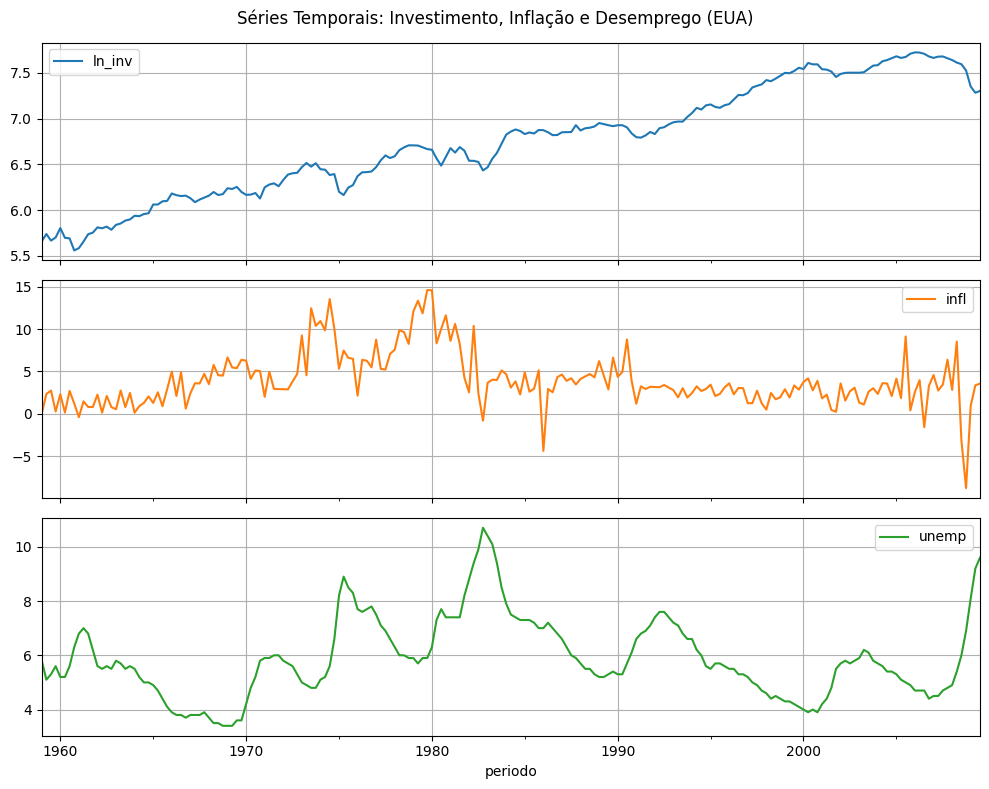

In [25]:
# %%
df.plot(subplots=True, figsize=(10,8))
plt.suptitle("Séries Temporais: Investimento, Inflação e Desemprego (EUA)")
plt.tight_layout()
plt.show()


_interpretando o output_

1) ln_inv — Log do Investimento Real

A série apresenta forte tendência de crescimento ao longo das décadas, com quedas visíveis em períodos de recessão (como 1973–75, 1981–82, 2001 e 2008). Esse comportamento indica não estacionariedade, coerente com variáveis macroeconômicas reais.

2) infl — Inflação

A inflação é marcadamente volátil, com picos significativos nos anos 1970 e início dos 1980 — período associado aos choques do petróleo e à política monetária mais frouxa da época. Após os anos 1990, a série se torna mais estável, sugerindo um regime de política monetária mais previsível.

3) unemp — Taxa de Desemprego

A taxa de desemprego oscila em ciclos de longo prazo, apresentando picos em fases recessivas da economia norte-americana. Esse padrão confirma o caráter cíclico e não estacionário da variável em nível.

> Estacionaridade das séries

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings

warnings.filterwarnings("ignore")

def adf_test(series, name="Série"):
    """
    Teste ADF com interpretação.
    H0: série possui raiz unitária (não estacionária).
    """
    serie = series.dropna()
    result = adfuller(serie, autolag="AIC")

    stat, pvalue, usedlag, nobs, crit, icbest = result

    print(f"\n====== Teste ADF: {name} ======")
    print(f"Estatística do teste: {stat:.4f}")
    print(f"p-valor: {pvalue:.4f}")
    print("Valores críticos:", crit)

    if pvalue < 0.05:
        print("➡ Conclusão: Rejeita H0 — A série é estacionária (I(0)).")
    else:
        print("➡ Conclusão: Não rejeita H0 — A série NÃO é estacionária (possível I(1)).")


def kpss_test(series, name="Série"):
    """
    Teste KPSS com interpretação.
    H0: série é estacionária em nível.
    """
    serie = series.dropna()

    try:
        stat, pvalue, lags, crit = kpss(serie, regression="c", nlags="auto")
    except Exception as e:
        print(f"\n[ERRO] KPSS falhou para a série {name}: {e}")
        return

    print(f"\n====== Teste KPSS: {name} ======")
    print(f"Estatística do teste: {stat:.4f}")
    print(f"p-valor: {pvalue}")
    print("Valores críticos:", crit)

    if pvalue < 0.05:
        print("➡ Conclusão: Rejeita H0 — A série NÃO é estacionária (possível I(1)).")
    else:
        print("➡ Conclusão: Não rejeita H0 — A série é estacionária (I(0)).")


# Rodando para todas as colunas
for col in df.columns:
    print("\n############################################################")
    adf_test(df[col], name=col)
    kpss_test(df[col], name=col)



############################################################

====== Teste ADF: ln_inv ======
Estatística do teste: -1.4268
p-valor: 0.5694
Valores críticos: {'1%': np.float64(-3.4633090972761744), '5%': np.float64(-2.876029332045744), '10%': np.float64(-2.5744932593252643)}
➡ Conclusão: Não rejeita H0 — A série NÃO é estacionária (possível I(1)).

====== Teste KPSS: ln_inv ======
Estatística do teste: 2.0468
p-valor: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
➡ Conclusão: Rejeita H0 — A série NÃO é estacionária (possível I(1)).

############################################################

====== Teste ADF: infl ======
Estatística do teste: -3.0545
p-valor: 0.0301
Valores críticos: {'1%': np.float64(-3.463476079125), '5%': np.float64(-2.876102355), '10%': np.float64(-2.574532225)}
➡ Conclusão: Rejeita H0 — A série é estacionária (I(0)).

====== Teste KPSS: infl ======
Estatística do teste: 0.3847
p-valor: 0.08376119796536807
Valores críticos: {'10%

_interpretando o output_

1) ln_inv (log do investimento real)

Ambos os testes ADF e KPSS indicam que ln_inv não é estacionário, confirmando que a série possui tendência estocástica típica de variáveis macroeconômicas reais. Isso sugere a necessidade de trabalhar com primeiras diferenças.

2) infl (inflação trimestral)

Os dois testes convergem para o mesmo diagnóstico: infl é estacionária em nível.
Isso é consistente com a natureza da variável, já que a inflação é uma taxa (variação), e não um nível acumulado. Portanto, pode ser usada no modelo sem diferenciação.

3) unemp (taxa de desemprego)

Os testes apresentam resultados mistos, mas com p-valor do ADF acima de 0,05.
Assim, o mais prudente — e alinhado com a literatura — é tratar unemp como não estacionária, considerando-a I(1) e aplicando a primeira diferença no VAR.

> Séries em VAR

          dln_inv  infl  dunemp
periodo                        
1959Q2   0.080213  2.34    -0.7
1959Q3  -0.072131  2.74     0.2
1959Q4   0.034425  0.27     0.3
1960Q1   0.102664  2.31    -0.4
1960Q2  -0.106694  0.14     0.0


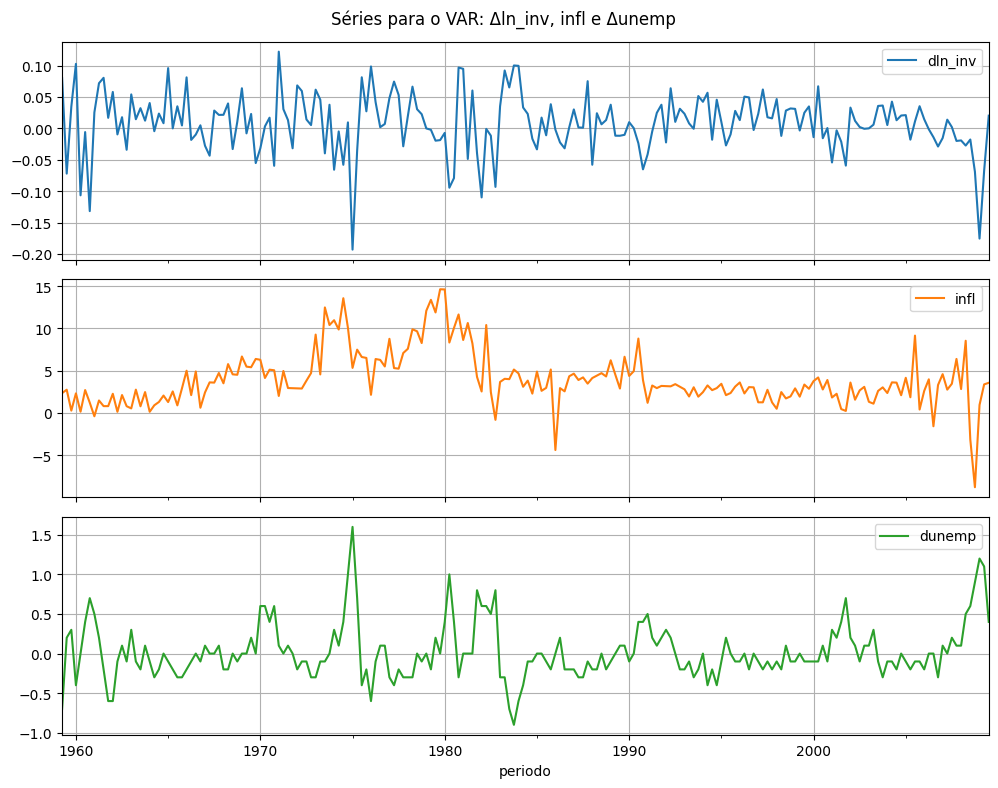

In [28]:
df_var = pd.DataFrame({
    "dln_inv": df["ln_inv"].diff(),   # diferença do log do investimento
    "infl": df["infl"],               # mantém em nível (já é I(0))
    "dunemp": df["unemp"].diff()      # diferença do desemprego
}).dropna()

print(df_var.head())

# (opcional) ver gráficos
df_var.plot(subplots=True, figsize=(10,8))
plt.suptitle("Séries para o VAR: Δln_inv, infl e Δunemp")
plt.tight_layout()
plt.show()


_interpretando os outputs_
1) Δln_inv — Variação do investimento real (estacionarizado)

A série em diferenças apresenta alta volatilidade em torno de zero, sem tendência aparente, confirmando estacionariedade. Os movimentos bruscos negativos em episódios como 1974, 1980 e 2008 refletem bem choques recessivos na economia americana.

2) infl — Inflação em nível (I(0))

Mesmo em nível, a inflação permanece estacionária e bem comportada, oscilando ao redor de médias diferentes conforme o regime monetário. A volatilidade elevada nos anos 1970 segue evidente, enquanto períodos posteriores apresentam dinâmica mais estável.

3) Δunemp — Variação da taxa de desemprego (estacionarizada)

A diferença do desemprego elimina o componente cíclico de longo prazo, resultando em uma série que oscila em torno de zero. Os picos positivos correspondem a momentos de deterioração rápida do mercado de trabalho, enquanto quedas acentuadas indicam recuperações econômicas.


In [29]:
from statsmodels.tsa.api import VAR

# %%
model = VAR(df_var)

# Selecionar ordem máxima (até 8 defasagens, por exemplo)
lag_results = model.select_order(maxlags=8)
print(lag_results.summary())

# Você pode escolher AIC, BIC, HQIC… vamos pegar AIC
p = lag_results.aic
print("Ordem escolhida (AIC):", p)


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -6.576      -6.525    0.001394      -6.555
1      -7.731      -7.529   0.0004389      -7.649
2      -7.976     -7.622*   0.0003437     -7.833*
3     -8.004*      -7.499  0.0003341*      -7.800
4      -8.002      -7.345   0.0003349      -7.736
5      -7.967      -7.158   0.0003472      -7.639
6      -7.976      -7.016   0.0003443      -7.587
7      -7.967      -6.855   0.0003477      -7.517
8      -7.914      -6.650   0.0003673      -7.402
-------------------------------------------------
Ordem escolhida (AIC): 3


_interpretando o output_

Os critérios de informação AIC, BIC, HQIC e FPE foram utilizados para selecionar a ordem ótima do modelo VAR. Os resultados indicam que o AIC atinge seu menor valor na ordem 3, sugerindo a escolha de um VAR(3). Os critérios BIC e HQIC, mais restritivos, apontam para a ordem 2, favorecendo modelos mais parcimoniosos.

A adoção de um VAR(3) é adequada neste caso, pois mantém boa capacidade explicativa, captura efeitos defasados relevantes entre as variáveis macroeconômicas analisadas e apresenta desempenho superior segundo o AIC e o FPE. A escolha é coerente com a literatura que utiliza dados trimestrais, onde modelos com duas ou três defasagens costumam ser suficientes para representar a dinâmica econômica.

In [30]:

var_results = model.fit(p)
print(var_results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 30, Nov, 2025
Time:                     21:04:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -7.36510
Nobs:                     199.000    HQIC:                  -7.66064
Log likelihood:          -34.8796    FPE:                0.000385364
AIC:                     -7.86158    Det(Omega_mle):     0.000332653
--------------------------------------------------------------------
Results for equation dln_inv
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.014454         0.005389            2.682           0.007
L1.dln_inv        -0.162886         0.089174           -1.827           0.068
L1.infl            0.001884         0.001309            1.439         

_interpretando o output_

O VAR(3) mostra que:
- A variação do investimento (dln_inv) responde principalmente às defasagens do desemprego, com L1.dunemp negativo e significativo.
- A inflação apresenta forte persistência nas próprias defasagens (L1, L2 e L3 significativas), além de algum efeito do investimento na primeira defasagem.
- A variação do desemprego é altamente persistente (L1.dunemp significativo), com influência moderada da inflação na segunda defasagem.
- A matriz de correlação dos resíduos indica relação contemporânea forte entre investimento 
e desemprego.


> Causalidade de Granger

In [31]:
# %% Causalidade: inflação → investimento
caus_infl = var_results.test_causality("dln_inv", ["infl"], kind="f")
print("=== Causalidade de Granger: infl -> dln_inv ===")
print(caus_infl.summary())

# %% Causalidade: desemprego → investimento
caus_unemp = var_results.test_causality("dln_inv", ["dunemp"], kind="f")
print("=== Causalidade de Granger: dunemp -> dln_inv ===")
print(caus_unemp.summary())


=== Causalidade de Granger: infl -> dln_inv ===
Granger causality F-test. H_0: infl does not Granger-cause dln_inv. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
         1.505          2.621   0.212 (3, np.int64(567))
--------------------------------------------------------
=== Causalidade de Granger: dunemp -> dln_inv ===
Granger causality F-test. H_0: dunemp does not Granger-cause dln_inv. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
         12.29          2.621   0.000 (3, np.int64(567))
--------------------------------------------------------


_interpretando o output_

Os testes mostram que a inflação não possui poder preditivo sobre a variação do investimento. 
Por outro lado, a variação do desemprego Granger-causa dln_inv, indicando relevância defasada do mercado de trabalho. 
Assim, apenas dunemp contribui para prever mudanças no investimento.


> Funções Impulso-Resposta

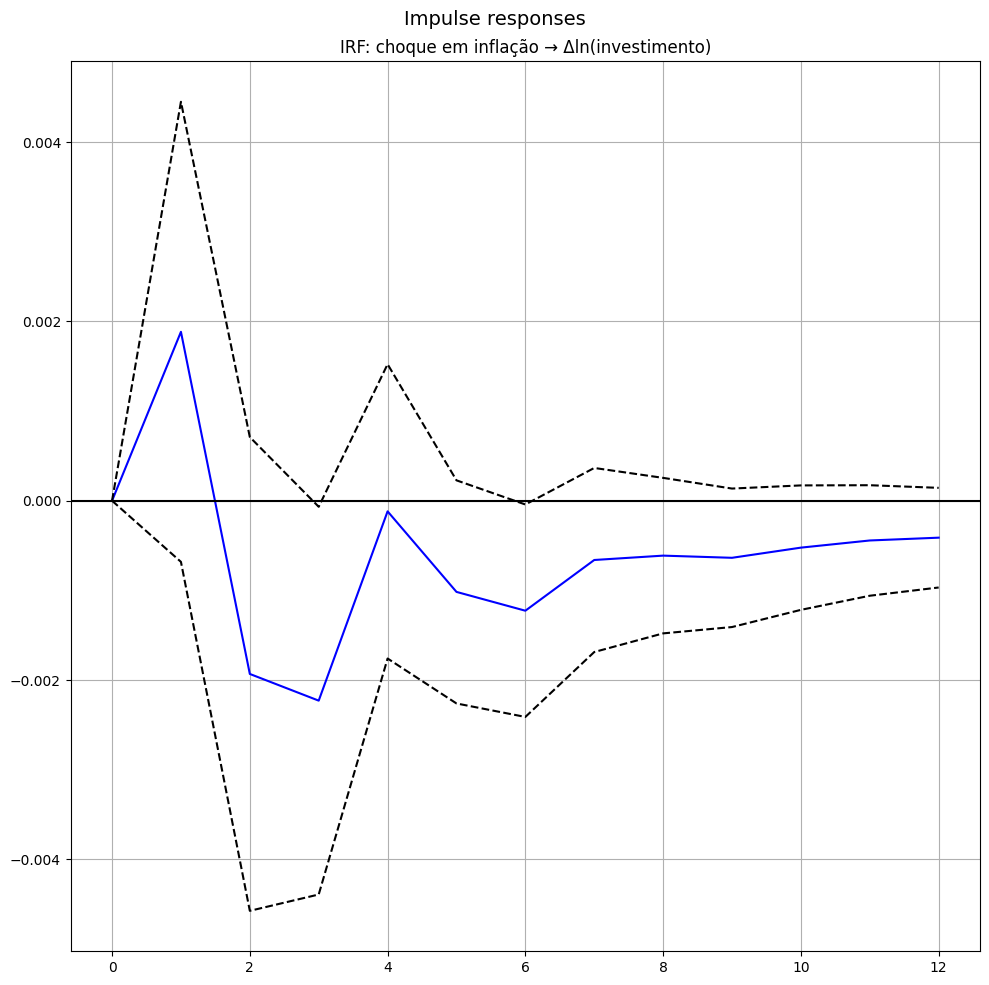

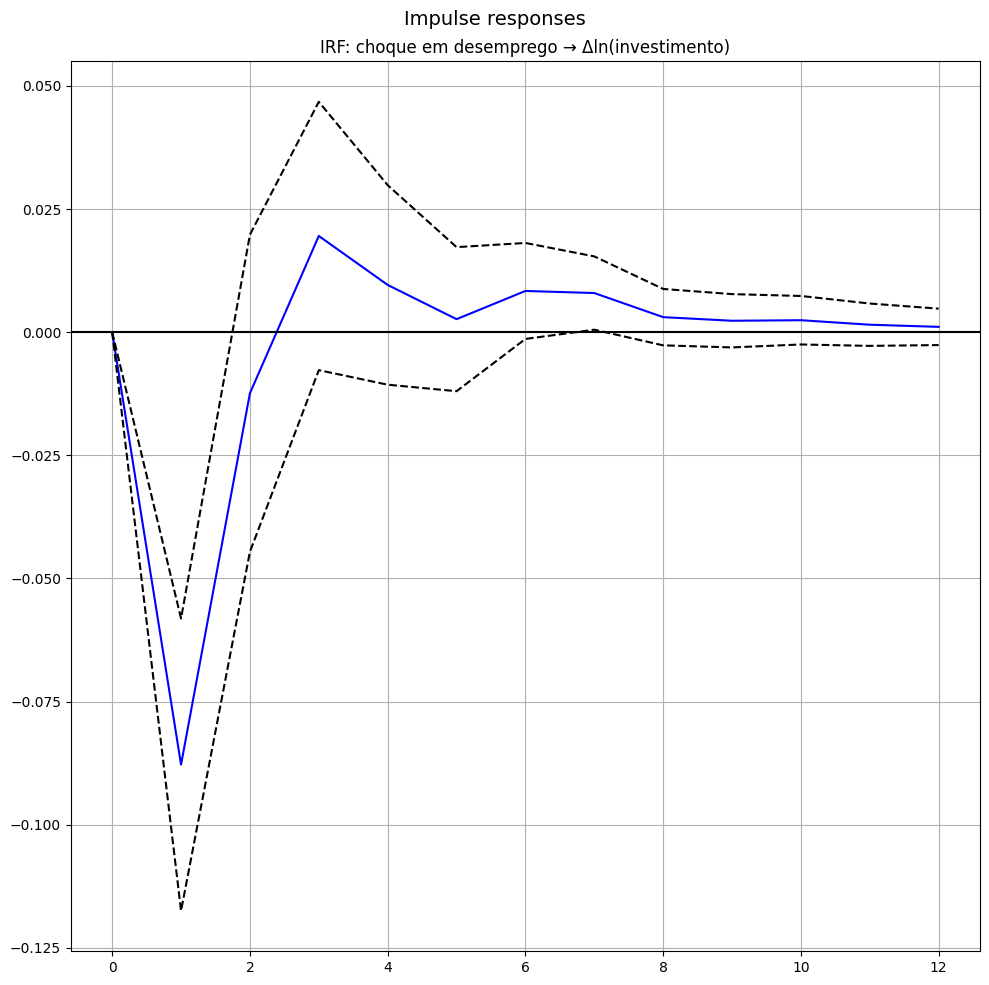

In [32]:

irf = var_results.irf(12)  # 12 trimestres de horizonte

# Resposta do investimento a um choque na inflação
irf.plot(impulse="infl", response="dln_inv")
plt.title("IRF: choque em inflação → Δln(investimento)")
plt.tight_layout()
plt.show()

# Resposta do investimento a um choque no desemprego
irf.plot(impulse="dunemp", response="dln_inv")
plt.title("IRF: choque em desemprego → Δln(investimento)")
plt.tight_layout()
plt.show()


_interpretando os outputs_
O choque na inflação gera um efeito inicial pequeno e negativo sobre o investimento, sem trajetória persistente. 
A resposta é instável nos primeiros períodos, mas converge rapidamente para zero. 
O impacto da inflação sobre o investimento é limitado e de curta duração.

Um choque no desemprego reduz o investimento de forma imediata e significativa. 
Após o impacto inicial, o efeito perde força e retorna gradualmente ao equilíbrio. 
O desemprego exerce influência mais forte e consistente sobre o investimento do que a inflação.


> FEVD (decomposição da variância)

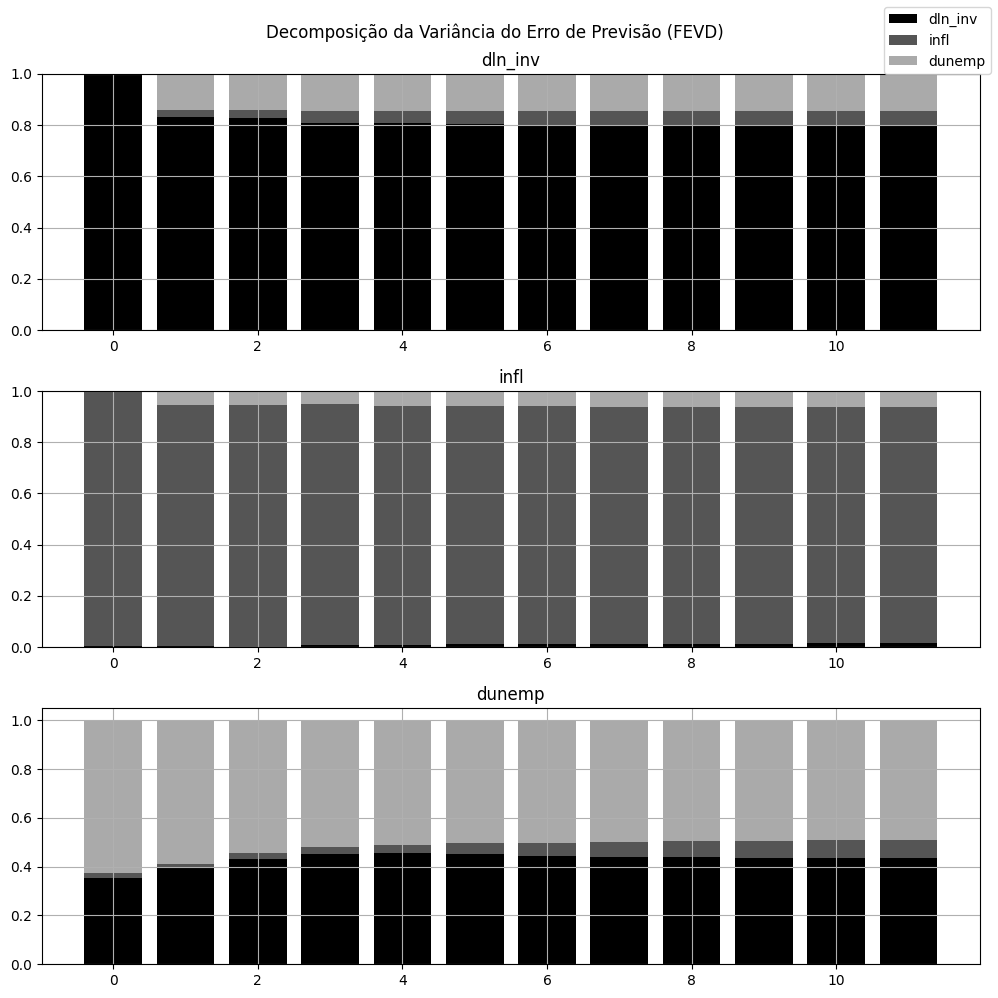

In [33]:
# %%
fevd = var_results.fevd(12)
fevd.plot()
plt.suptitle("Decomposição da Variância do Erro de Previsão (FEVD)")
plt.tight_layout()
plt.show()


_interpretando o output_

A variação do investimento é explicada majoritariamente pelos seus próprios choques, 
com contribuição moderada do desemprego ao longo dos horizontes. 
A inflação pouco contribui para explicar a variância de dln_inv, reforçando sua baixa relevância preditiva.
